# **rnnを実装してみる**

### **必要な関数・ライブラリ等の準備**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [27]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

## **データの準備**

In [4]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    output_data = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # train_kwhをエクセル等で開くとdatetimeが指数表示に直される可能性がある
    # その場合うまくいかないので201201010120の形になってることを確認する必要あり
    output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

    # datetimeの行をpd.Timestampのインスタンスに変更
    output_data = set_time(output_data, 'datetime')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに合計を集計
    output_data = output_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    output_data.to_csv('data/processed_data/out_put.tsv', sep='\t') 
    
output_data.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:00:00,0,0.0,NaN
1,2012-01-01 00:30:00,0,0.0,NaN
2,2012-01-01 01:00:00,0,0.0,NaN
3,2012-01-01 01:30:00,0,0.0,NaN
4,2012-01-01 02:00:00,0,0.0,NaN


In [5]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    amd_data = pd.read_csv('data/processed_data/amd_data.tsv', delimiter='\t')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # 河口湖アメダスのデータを使って予測する, amd_49251
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49251.tsv', delimiter = '\t')

    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに平均を集計
    amd_data = amd_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).mean()

    amd_data.to_csv('data/processed_data/amd_data.tsv', sep='\t')

amd_data.head()

,datetime,pr,f_pr,max_ws,f_max_ws,ave_wv,f_ave_wv,ave_ws,f_ave_ws,max_tp,f_max_tp,min_tp,f_min_tp,sl,f_sl,sd,f_sd,dsd,f_dsd
0,2012-01-01 00:00:00,0.0,0.0,22.333333,0.0,20.333333,0.0,10.000000,0.0,-15.666667,0.0,-26.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2012-01-01 00:30:00,0.0,0.0,15.333333,0.0,25.000000,0.0,9.333333,0.0,-34.666667,0.0,-40.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,2012-01-01 01:00:00,0.0,0.0,20.000000,0.0,25.000000,0.0,10.666667,0.0,-35.333333,0.0,-43.666667,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,2012-01-01 01:30:00,0.0,0.0,20.333333,0.0,21.666667,0.0,11.333333,0.0,-36.666667,0.0,-42.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,2012-01-01 02:00:00,0.0,0.0,25.333333,0.0,21.000000,0.0,13.333333,0.0,-40.666667,0.0,-48.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [30]:
# モデル構築のためにデータを分割する

# 日射量の欠損値を一つ前の値で置換/output_dataに関してはSOLA01はnullなし
amd_data['sl'] = amd_data['sl'].fillna(method='bfill')

# 学習に必要なデータ
# 2012/01/01 00:00 ~ 2015/12/30 20:00のamdデータを用いて
# 2012/01/03 03:30 ~ 2015/12/31 23:30のデータを予測する
train_x_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-03 03:30')].index[0]
train_y_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

train_amd_data = np.array(amd_data['sl'][train_x_startID:(train_x_endID+1)])
train_output_data = np.array(output_data['SOLA01'][train_y_startID:(train_y_endID+1)])

# 予測に必要なデータ
# 2015/12/30 20:30 ~ 2017/3/30 20:00のamdデータを用いて
# 2016/01/01 00:00 ~ 2017/3/31 23:30のoutputデータを予測する
test_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:30')].index[0]
test_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]

test_amd_data = list(amd_data['sl'][test_startID:(test_endID+1)])

In [103]:
# rnnに突っ込むための準備

chunk_size = 49

# rnnに突っ込むために正規化しておく
amd_min, amd_max, normalized_amd = normalize_array(train_amd_data)
output_min, output_max, normalized_output = normalize_array(train_output_data)
test_amd_min, test_amd_max, normalized_test_amd = normalize_array(test_amd_data)

#時系列データのリストにする
input_list = []
for i in range(0, len(normalized_amd) - chunk_size + 1):
    input_list.append(normalized_amd[i : i + chunk_size])
input_list = np.array(input_list)

test_input_list = []
for i in range(0, len(normalized_test_amd) - chunk_size + 1):
    test_input_list.append(normalized_test_amd[i : i + chunk_size])
test_input_list = np.array(test_input_list)

# RNNに突っ込むためにデータを整形
X = np.array(input_list).reshape(len(input_list), chunk_size, 1)
Y = np.array(normalized_output).reshape(len(input_list), 1 )
X_predict = np.array(test_input_list).reshape(len(test_input_list), chunk_size, 1)

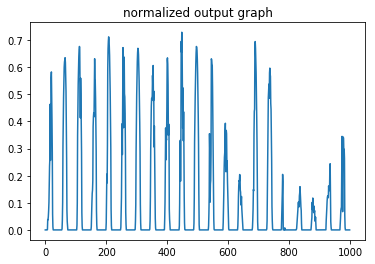

In [98]:
plt.plot(normalized_output[0:1000])
plt.title("normalized output graph")

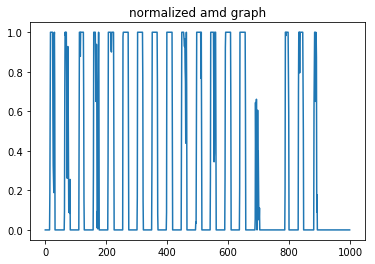

In [99]:
plt.plot(normalized_amd[0:1000])
plt.title("normalized amd graph")

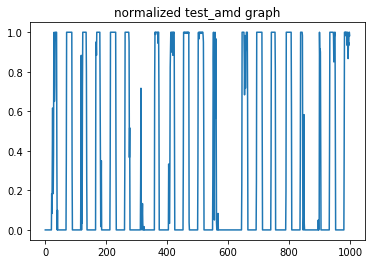

In [107]:
plt.plot(normalized_test_amd[0:1000])
plt.title("normalized test_amd graph")

### **モデルの構築**

前日の20時までの山梨県富士河口湖のアメダスの日射量データを用いて翌日の00:00~23:30を予測する

前日の20時までのデータしか使えないので川崎近くのアメダスデータを使うのは予測として適切か疑問だったのでとりあえず1日程度ラグがありそうな(※要出典)ここのデータをつかう

(例)

8/17の00:00 ~ 23:30を予測するとき

8/17の23:30を8/15 20:00 ~ 8/16 20:00

8/17の23:00を8/15 19:30 ~ 8/16 19:30

....

8/17の00:00を8/14 20:30 ~ 8/15 20:30で予測する

参考サイト：http://www.madopro.net/entry/char_level_lm_with_simple_rnn

　　　　　　https://qiita.com/yukiB/items/f6314d2861fc8d9b739f

          https://www.tensorflow.org/install/migration
          

In [117]:
class simpleLSTM:
    def __init__(self, X, Y):
        '''
        諸変数の設定
        '''
        self.input_layer_size = 1 #入力層の数、一つ一つのデータはslの値ひとつだけなので1
        self.hidden_layer_size = 100 # 隠れ層の数、とりあえず系列データの長さ分だけ用意しておく
        self.output_layer_size = 1 #出力層の数、求める値は時間あたりの発電量の値1つなので1
        self.batch_size = 200 #バッチサイズ、適当
        self.chunk_size = 49 # 一回の系列データの長さ
        self.learning_rate = 0.01 # 学習率 適当
        self.forget_bias = 0.8  # 忘却率
        self.epochs = 100 #エポック数
        
        # 学習データと検証用データに分けておく
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.1)))
        self.X = X # 入力
        self.Y = Y # 教師
        self.X_val = X_val # 検証用
        self.Y_val = Y_val #検証用
        
    def shuffle(self):
        '''
        ミニバッチかする際にランダムにシャッフル
        '''
        idx = [i for i in range(self.X.shape[0])]
        np.random.shuffle(idx)
        xs = np.array([[y for y in list(self.X[r])] for r in idx])
        ys = np.array([self.Y[r] for r in idx])
        return xs, ys
        
    def inference(self, input_ph, inistate_ph):
        '''
        グラフの構築
        '''
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01), name='hidden_w')
        hidden_b = tf.Variable(tf.truncated_normal([self.hidden_layer_size]), name='hidden_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        #　input_phの整型  
        in1 = tf.transpose(input_ph, [1, 0, 2]) 
        in2 = tf.reshape(in1, [-1, self.input_layer_size]) 
        in3 = tf.matmul(in2, hidden_w) + hidden_b
        in4 = tf.split(in3, self.chunk_size, 0)
          
            
        # BasicLSTMCellを定義
        cell = tf.contrib.rnn.BasicLSTMCell(self.hidden_layer_size, forget_bias=self.forget_bias, state_is_tuple=False)
        rnn_outputs, states = tf.contrib.rnn.static_rnn(cell, in4, initial_state=inistate_ph)
        output = tf.matmul(rnn_outputs[-1], output_w) + output_b
        results = [hidden_w, output_w, hidden_w, hidden_b]
        return output, states, results
        
    def loss(self, output_ph, actual_ph):
        '''
        お題と同じmean absolute errorを仕様
        '''
        cost = tf.reduce_mean(tf.abs(output_ph - actual_ph))
        tf.summary.scalar('loss', cost)
        return cost
    
    def training(self, cost):
        '''
        adamを仕様beta1, beta2は元論文の推奨値を仕様
        '''
        with tf.name_scope("training") as scope:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
            return optimizer
    
    def train(self):
        '''
        学習
        '''
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        n_batch = self.X.shape[0] // self.batch_size
        
        with tf.Graph().as_default():
            # 変数の用意
            input_ph = tf.placeholder('float', [None, self.chunk_size, self.input_layer_size], name='input')
            actual_ph = tf.placeholder('float', [None, self.output_layer_size], name='actual_value')
            inistate_ph = tf.placeholder('float', [None, self.hidden_layer_size * 2], name='inistate')

            prediction, state, weights = self.inference(input_ph, inistate_ph)
            cost = self.loss(prediction, actual_ph)
            optimizer = self.training(cost)

            # TensorBoardで可視化する
            summary = tf.summary.merge_all()
            # 初期化
            init = tf.global_variables_initializer()
                
            # ここから学習
            with tf.Session() as sess:
                # 学習したモデルも保存しておく
                saver = tf.train.Saver()
                summary_writer = tf.summary.FileWriter("/tmp/tensorflow_log", graph=sess.graph)
                sess.run(init)

                for epoch in range(self.epochs):
                    X_, Y_ = self.shuffle()
                    for i in range(n_batch):
                        start = i * self.batch_size
                        end = start + self.batch_size
                        inputs  = X_[start:end]
                        actuals = Y_[start:end]
                        train_dict = {
                            input_ph:      inputs,
                            actual_ph:     actuals,
                            inistate_ph:     np.zeros((self.batch_size, self.hidden_layer_size * 2)),
                        }
                    
                    sess.run(optimizer, feed_dict=train_dict)

                    if (epoch) % 10 == 0:
                        val_dict = {
                            input_ph:      self.X_val,
                            actual_ph:     self.Y_val,
                            inistate_ph:     np.zeros((self.X_val.shape[0], self.hidden_layer_size * 2)),
                        }
                        summary_str, train_loss = sess.run([summary, cost], feed_dict=val_dict)
                        print("train#%d, train loss: %e" % (epoch, train_loss))
                        summary_writer.add_summary(summary_str, epoch)
                        
                datas = sess.run(weights)
                saver.save(sess, "./data/model/wiki2.ckpt")
                
    def predict(self, X_predict):
        '''
        予測期間に該当するデータから予測
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.chunk_size, self.input_layer_size], name='input')
        inistate_ph = tf.placeholder("float", [None, self.hidden_layer_size * 2], name='inistate')
        prediction, state, weights = self.inference(input_ph, inistate_ph)
        pre_dict = {
            input_ph: X_predict,
            inistate_ph: np.zeros((X_predict.shape[0], self.hidden_layer_size*2))
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess, "./data/model/wiki2.ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)


        return expected_output

In [118]:
model_01 = simpleLSTM(X, Y)

In [113]:
model_01.train()

train#0, train loss: 2.651262e-01
train#10, train loss: 1.698646e-01
train#20, train loss: 1.683265e-01
train#30, train loss: 1.749960e-01
train#40, train loss: 1.669553e-01
train#50, train loss: 1.598880e-01
train#60, train loss: 1.689372e-01
train#70, train loss: 1.588783e-01
train#80, train loss: 1.566330e-01
train#90, train loss: 1.684986e-01


In [143]:
predict = model_01.predict(X_predict)
predict = np.array(predict).reshape(len(predict[0]))

In [144]:
# 2016/01/01 00:00 ~ 2017/3/31 23:30の予測データを書き出す
s_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
predict_data = pd.DataFrame({"datetime":amd_data['datetime'][s_idx:e_idx+1], "expected_output":predict})
predict_data.index = np.arange(len(predict_data))

ValueError: array length 21840 does not match index length 21888

,datetime
0,2016-01-01 00:00:00
1,2016-01-01 00:30:00
2,2016-01-01 01:00:00
3,2016-01-01 01:30:00
4,2016-01-01 02:00:00
5,2016-01-01 02:30:00
6,2016-01-01 03:00:00
7,2016-01-01 03:30:00
8,2016-01-01 04:00:00
9,2016-01-01 04:30:00
